# Классификация MNIST сверточной сетью

https://www.kaggle.com/c/digit-recognizer

In [ ]:
!wget https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
!unzip digit-recognizer.zip 

--2021-08-25 17:53:38--  https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9wrovo5cugw8xdu/digit-recognizer.zip [following]
--2021-08-25 17:53:39--  https://www.dropbox.com/s/raw/9wrovo5cugw8xdu/digit-recognizer.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f5f4cea2afc029cb61dd9a644.dl.dropboxusercontent.com/cd/0/inline/BU5LVtUUGJr0VWPIsCCV_SVW6tUOgnilAu7eK7RwusakZ9kJLOcIZXplY4kTOw1mAugOzHFdXw6j7kqf8ZEVWwlHjaecqBlAHAg4iYlKZPUKwfeAg7APbl7hMx7MZ1JSrHjUjBZ0DmgO0r5ipHwngU8j/file# [following]
--2021-08-25 17:53:39--  https://uc7f5f4cea2afc029cb61dd9a644.dl.dropboxusercontent.com/cd/0/inline/BU5LVtUUGJr0VWPIsCCV_SVW6tUOgnilAu7eK7RwusakZ9kJLOcIZXplY4kTOw1mA

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

## Визуализируем исходные данные

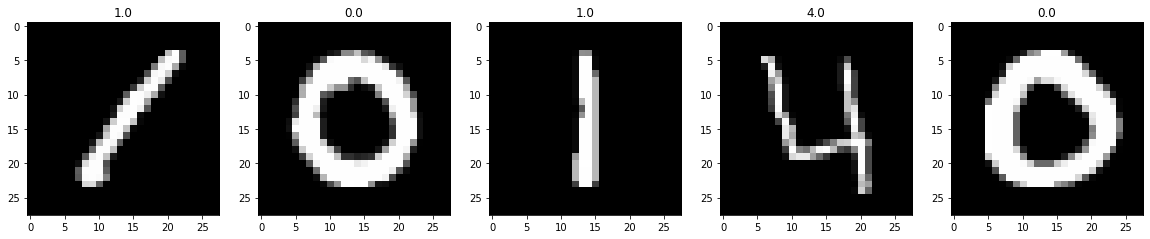

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

## Собираем сверточную сеть для обучения

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='valid',
                           activation='relu',
                           input_shape=x_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=None),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

## One-hot кодировка разметки

In [ ]:
y_train

array([6., 5., 3., ..., 2., 6., 0.])

In [ ]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [ ]:
y_train_labels[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
print(y_train.shape)
print(y_train_labels.shape)

(33600,)
(33600, 10)


## Запускаем обучение

In [ ]:
model.fit(x_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5
840/840 [==============================] - 6s 4ms/step - loss: 2.5836 - accuracy: 0.2858 - val_loss: 1.1526 - val_accuracy: 0.6338
Epoch 2/5
840/840 [==============================] - 3s 3ms/step - loss: 1.4341 - accuracy: 0.4908 - val_loss: 0.6082 - val_accuracy: 0.8714
Epoch 3/5
840/840 [==============================] - 3s 3ms/step - loss: 1.0679 - accuracy: 0.6118 - val_loss: 0.3309 - val_accuracy: 0.9202
Epoch 4/5
840/840 [==============================] - 3s 3ms/step - loss: 0.7983 - accuracy: 0.7039 - val_loss: 0.2272 - val_accuracy: 0.9485
Epoch 5/5
840/840 [==============================] - 3s 3ms/step - loss: 0.6566 - accuracy: 0.7570 - val_loss: 0.1761 - val_accuracy: 0.9558


## Предсказываем класс объекта

In [ ]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

## Оцениваем качество решение на валидационной выборке

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred_labels))

Accuracy: 0.955952380952381


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       816
         1.0       0.99      0.98      0.99       909
         2.0       0.95      0.96      0.96       846
         3.0       0.96      0.94      0.95       937
         4.0       0.98      0.94      0.96       839
         5.0       0.96      0.93      0.95       702
         6.0       0.95      0.99      0.97       785
         7.0       0.96      0.95      0.95       893
         8.0       0.92      0.96      0.94       835
         9.0       0.90      0.93      0.91       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



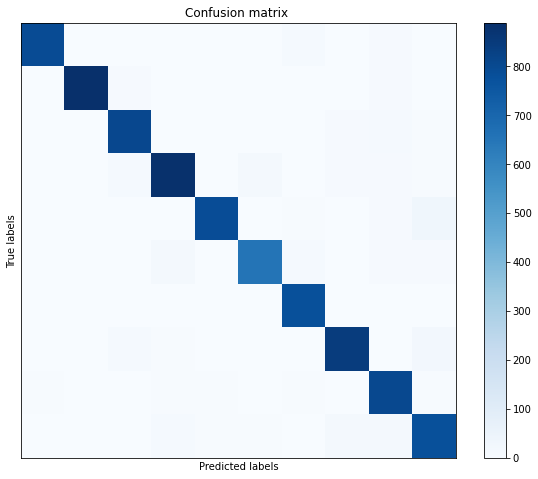

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

## Визуализируем предсказания для тестовой выборки

In [ ]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

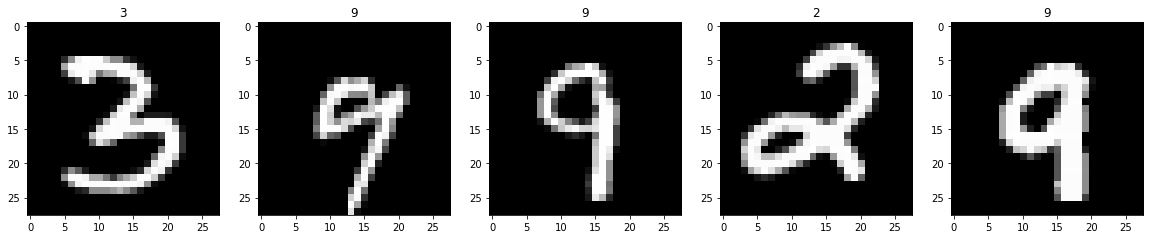

In [ ]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(test_img)), 5)
img_prediction = zip(test_img[indices], y_pred_test_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('%d' % pred);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test_labels, 1):
        dst.write('%s,%d\n' % (i, p))

In [ ]:
# Your submission scored 0.96814

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
!nvidia-smi

Wed Aug 25 17:55:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |   1244MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------